In [ ]:
!pip install kaggle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split

import numpy as np
import h5py
import time
from multiprocessing import Pool

if not os.path.exists('./plantvillage'):
    print("Dataset non trovato. Download in corso...")

    # Installa kaggle se non presente
    !pip install -q kaggle

    from google.colab import files
    # Upload del file kaggle.json solo se non esiste
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        files.upload()  # Upload file kaggle.json

        # Configura le credenziali Kaggle
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

    # Download e estrazione del dataset
    !kaggle datasets download -d abdallahalidev/plantvillage-dataset
    !unzip plantvillage-dataset.zip -d ./plantvillage
    print("Dataset scaricato e estratto con successo!")
else:
    print("Dataset già presente in ./plantvillage")

Dataset già presente in ./plantvillage


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json

# Configurazione
IMG_SIZE = 224  # MobileNetV2 richiede input 224x224
BATCH_SIZE = 32
EPOCHS = 15
DATA_DIR = "plantvillage/plantvillage dataset/color"  # Cartella con sottocartelle per ogni classe

def create_data_generators():
    import os
    from sklearn.model_selection import train_test_split
    import pandas as pd

    # Preparazione dei file: ottieni la directory dei dati e le classi disponibili
    all_data_dir = os.path.join(DATA_DIR)  # Percorso alla directory principale
    classes = sorted(os.listdir(all_data_dir))  # Elenco delle sottodirectory (una per classe)
    with open('/content/drive/My Drive/classes.json', 'w') as f:
        json.dump(classes, f)

    # Creazione delle liste di percorsi dei file e delle rispettive etichette
    all_filepaths = []
    all_labels = []
    for label, class_dir in enumerate(classes):
        class_files = os.listdir(os.path.join(all_data_dir, class_dir))  # Tutti i file per una classe
        all_filepaths.extend([os.path.join(all_data_dir, class_dir, f) for f in class_files])  # Percorsi completi
        all_labels.extend([label] * len(class_files))  # Etichetta numerica corrispondente

    # Suddivisione in train, validation e test usando stratificazione per bilanciare le classi
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        all_filepaths, all_labels, test_size=0.3, stratify=all_labels, random_state=42
    )
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    # Configurazione per il data augmentation (solo per il training set)
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalizza i valori dei pixel tra 0 e 1
        rotation_range=20,  # Rotazione casuale delle immagini
        width_shift_range=0.2,  # Traslazione orizzontale casuale
        height_shift_range=0.2,  # Traslazione verticale casuale
        horizontal_flip=True,  # Flip orizzontale casuale
        fill_mode='nearest'  # Riempimento dei pixel vuoti dopo trasformazioni
    )

    # Configurazione per il validation e il test set (solo rescaling)
    test_valid_datagen = ImageDataGenerator(rescale=1./255)

    # Generatori per i dati
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': [classes[label] for label in train_labels]}),
        x_col='filename',  # Colonna con i percorsi delle immagini
        y_col='class',  # Colonna con le etichette (in formato stringa per compatibilità)
        target_size=(IMG_SIZE, IMG_SIZE),  # Ridimensiona le immagini
        batch_size=BATCH_SIZE,  # Dimensione del batch
        class_mode='categorical',  # Problema di classificazione
        shuffle=True  # Shuffle dei dati per il training
    )

    validation_generator = test_valid_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': [classes[label] for label in val_labels]}),
        x_col='filename',
        y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Nessuno shuffle per il validation set
    )

    test_generator = test_valid_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': test_files, 'class': [classes[label] for label in test_labels]}),
        x_col='filename',
        y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Nessuno shuffle per il test set
    )

    return train_generator, validation_generator, test_generator

In [ ]:
def create_model(num_classes):
    # Carica MobileNetV2 pre-allenato su ImageNet
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Congela i layer del modello base
    base_model.trainable = False

    # Aggiunge layers custom
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    #x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

def train_model(model, train_generator, validation_generator):
    # Compila il modello
    model.compile(
        optimizer=tf.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Training
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )

    return history

def fine_tune_model(model, base_model, train_generator, validation_generator):
    # Sblocca gli ultimi layers del modello base
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Ricompila con learning rate più basso
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tuning
    history_fine = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
    )

    return history_fine

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def evaluate_model(model, validation_generator):
    # Predizioni
    predictions = model.predict(validation_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = validation_generator.classes

    # Report di classificazione
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=list(validation_generator.class_indices.keys())
    ))

    # Matrice di confusione
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=validation_generator.class_indices.keys(),
        yticklabels=validation_generator.class_indices.keys()
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    # Preparazione dei dati
    train_generator, validation_generator, test_generator = create_data_generators()
    num_classes = len(train_generator.class_indices)
    import json
    with open('/content/drive/My Drive/class_indices.json', 'w') as f:
        json.dump(train_generator.class_indices, f)

    # Creazione e training del modello
    model, base_model = create_model(num_classes)
    print("Training initial model...")
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print("number parameters: ", model.count_params(), ", number trainable:", trainable_params)
    history = train_model(model, train_generator, validation_generator)
    plot_training_history(history)

    # Valutazione
    print("\nEvaluating the model...")
    evaluate_model(model, test_generator)

    # Salva il modello
    #keras.saving.save_model(model, 'plant_disease_model.keras')
    model.save('/content/drive/My Drive/plant_disease_model2.keras')
    model.save('/content/drive/My Drive/plant_disease_model2.h5')
    print("\nModel saved as 'plant_disease_model.h5'")

    # Fine-tuning
    print("\nFine-tuning the model...")
    history_fine = fine_tune_model(model, base_model, train_generator, validation_generator)
    plot_training_history(history_fine)

    # Valutazione dopo fine-tuning
    print("\nEvaluating the model...")
    evaluate_model(model, test_generator)

    # Salva il modello dopo fine-tuning
    #keras.saving.save_model(model, 'plant_disease_model_tuned.keras')
    model.save('/content/drive/My Drive/plant_disease_model_tuned2.keras')
    model.save('/content/drive/My Drive/plant_disease_model_tuned2.h5')
    model.save('plant_disease_model_tuned.h5')
    print("\nModel saved as 'plant_disease_model.h5'")

Found 38013 validated image filenames belonging to 38 classes.
Found 8146 validated image filenames belonging to 38 classes.
Found 8146 validated image filenames belonging to 38 classes.
Training initial model...
number parameters:  2306662 , number trainable: 48678
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 428s 351ms/step - accuracy: 0.7433 - loss: 0.9907 - val_accuracy: 0.9141 - val_loss: 0.2907
Epoch 2/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 406s 340ms/step - accuracy: 0.9202 - loss: 0.2606 - val_accuracy: 0.9239 - val_loss: 0.2430
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 407s 341ms/step - accuracy: 0.9305 - loss: 0.2091 - val_accuracy: 0.9251 - val_loss: 0.2233
Epoch 4/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 407s 340ms/step - accuracy: 0.9418 - loss: 0.1860 - val_accuracy: 0.9260 - val_loss: 0.2193
Epoch 5/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 407s 341ms/step - accuracy: 0.9467 - loss: 0.1657 - val_accuracy: 0.9326 - val_loss: 0.2033
Epoch 6/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 407s 340ms/step - accuracy: 0.9463 - loss: 0.1569 - val_accuracy: 0.9386 - val_loss: 0.1893
Epoch 7/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 407s 340ms/step - accuracy: 0.9512 - loss: 0.1428 - val_accuracy: 0.9295 - val_loss: 0.2123
Epoch 8/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 405s 339ms/step - accuracy: 0.9

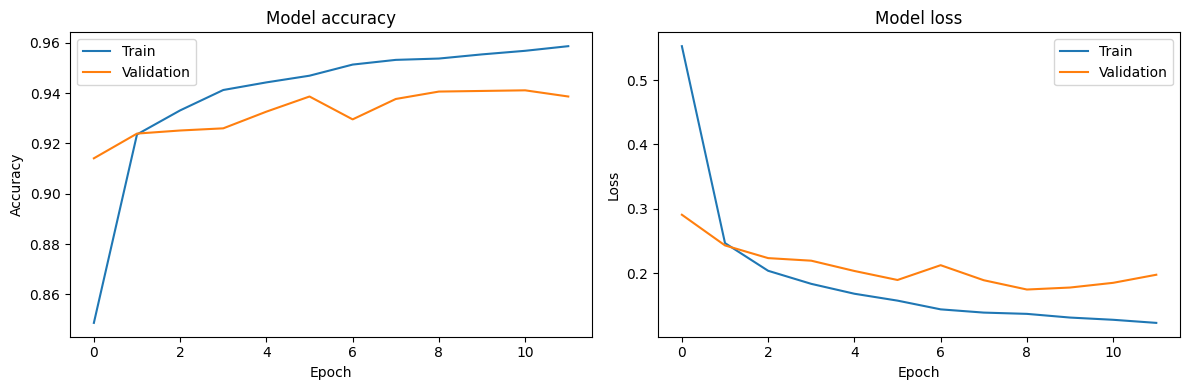


Evaluating the model...
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.95      0.94        94
                                 Apple___Black_rot       0.92      0.99      0.95        93
                          Apple___Cedar_apple_rust       0.98      0.98      0.98        41
                                   Apple___healthy       0.96      0.99      0.98       246
                               Blueberry___healthy       0.99      0.94      0.96       226
          Cherry_(including_sour)___Powdery_mildew       0.96      0.98      0.97       158
                 Cherry_(including_sour)___healthy       0.99      1.00      1.00       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.68      0.78        77
                       Corn_(maize)___Common_rust_       0.98      0.99      0.

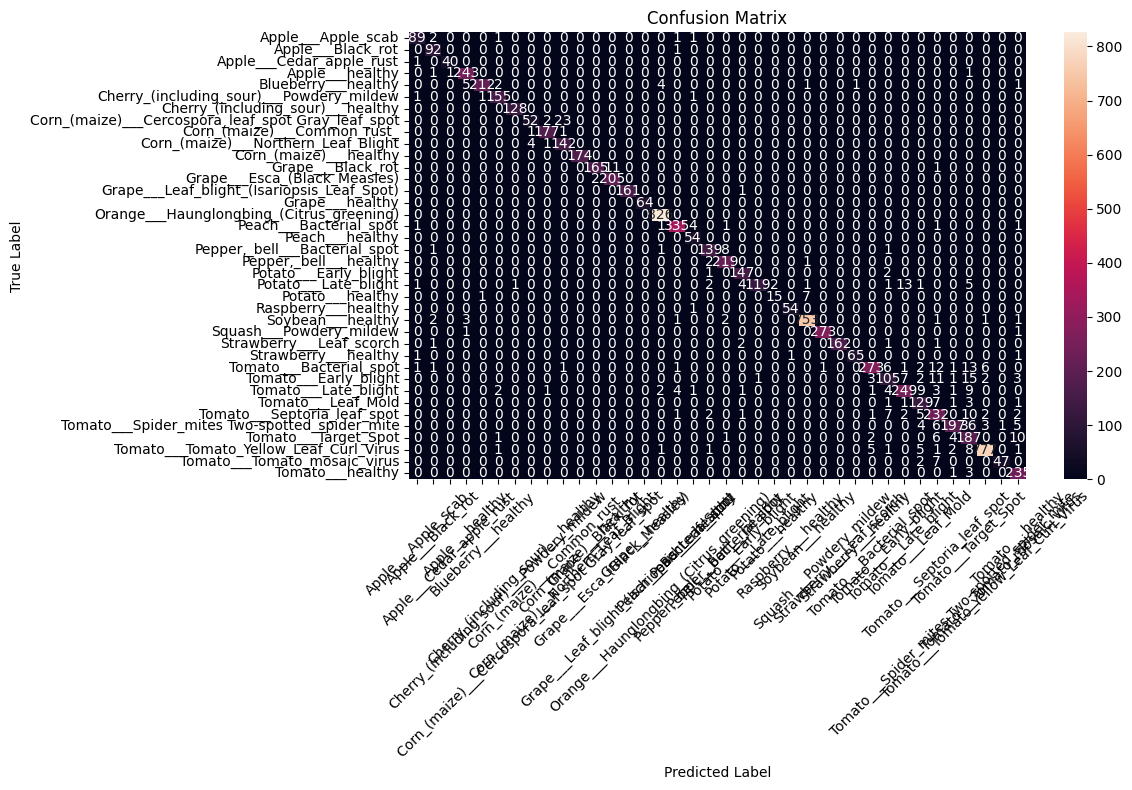


Model saved as 'plant_disease_model.h5'

Fine-tuning the model...
Epoch 1/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 432s 351ms/step - accuracy: 0.9055 - loss: 0.3159 - val_accuracy: 0.9286 - val_loss: 0.2851
Epoch 2/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 410s 343ms/step - accuracy: 0.9598 - loss: 0.1172 - val_accuracy: 0.9467 - val_loss: 0.2066
Epoch 3/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 408s 342ms/step - accuracy: 0.9713 - loss: 0.0814 - val_accuracy: 0.9462 - val_loss: 0.2075
Epoch 4/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 411s 344ms/step - accuracy: 0.9767 - loss: 0.0670 - val_accuracy: 0.9633 - val_loss: 0.1327
Epoch 5/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 410s 343ms/step - accuracy: 0.9770 - loss: 0.0647 - val_accuracy: 0.9439 - val_loss: 0.2245
Epoch 6/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 410s 343ms/step - accuracy: 0.9820 - loss: 0.0520 - val_accuracy: 0.9584 - val_loss: 0.1640
Epoch 7/10
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 408s 341ms/step - accuracy: 0.9835 - loss: 0.0461 - val_accuracy: 0.9634 - val_loss: 0.

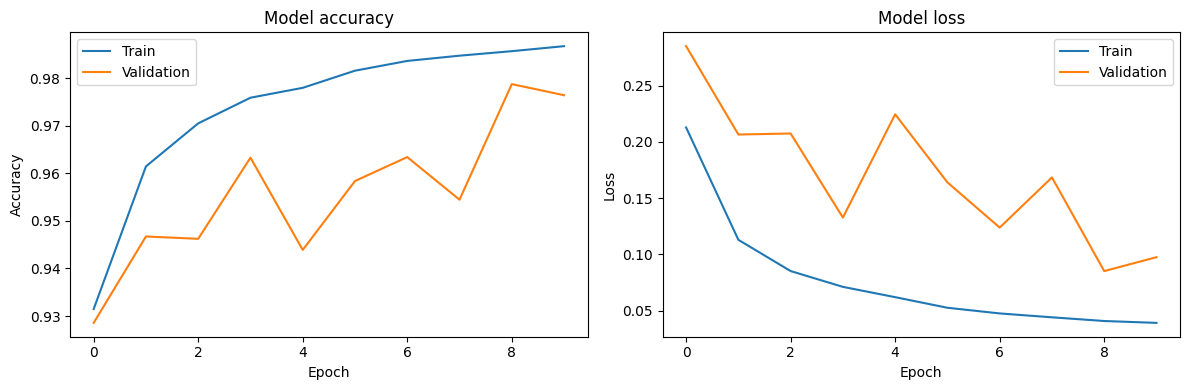


Evaluating the model...
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.91      0.95        94
                                 Apple___Black_rot       0.95      1.00      0.97        93
                          Apple___Cedar_apple_rust       0.98      0.98      0.98        41
                                   Apple___healthy       0.98      1.00      0.99       246
                               Blueberry___healthy       0.98      1.00      0.99       226
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       158
                 Cherry_(including_sour)___healthy       0.98      1.00      0.99       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.78      0.95      0.86        77
                       Corn_(maize)___Common_rust_       1.00      0.99      0.

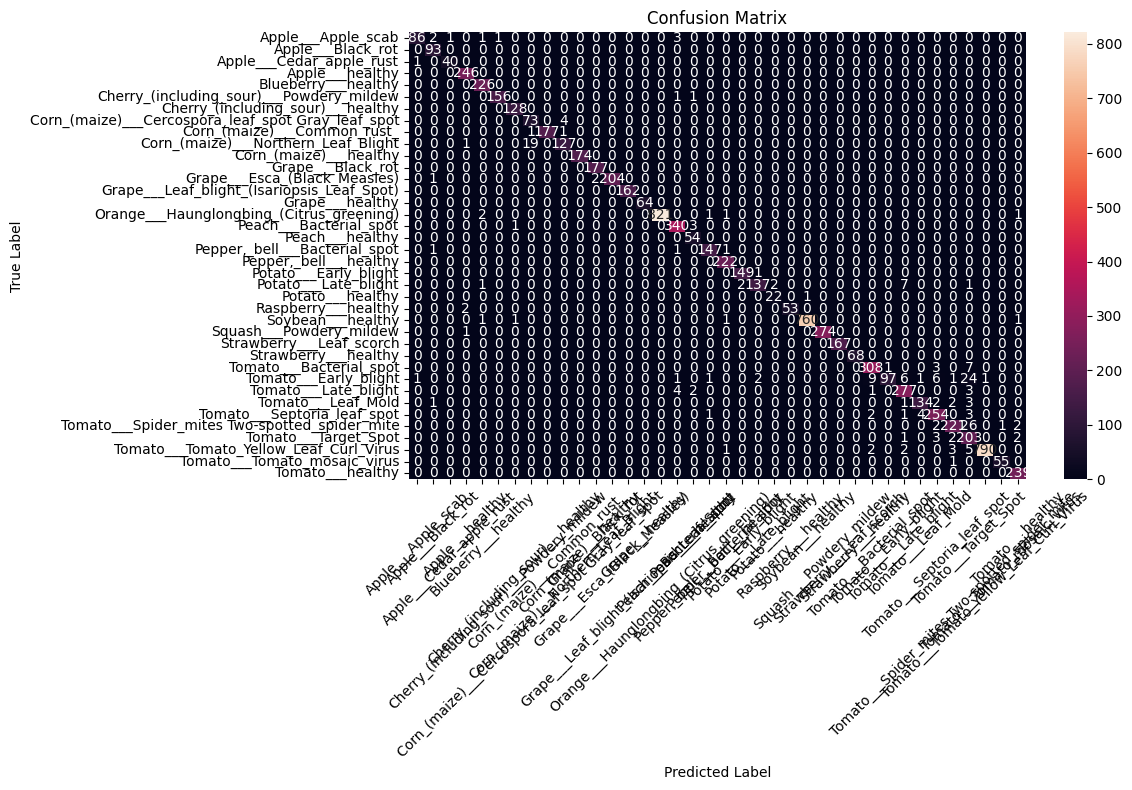


Model saved as 'plant_disease_model.h5'


In [ ]:
main()